
## **Table of Contents**
* [Section 1](#section-1) Setup for COLAB
* [Section 2](#section-2) Preprocess of Dataset
  * [Subsection 2.1](#subsection-2.1) Extract all images from hdf5 files to separate directories
  * [Subsection 2.2](#subsection-2.2) Solve imbalanced training set via weighted class approach
  * [Subsection 2.3](#subsection-2.3) Define a transfer function for Morphological Transformations and Histogram equalisation
* [Section 3](#section-3) Train a CNN model using transfer learning
* [Section 4](#section-4) Evaluate trained model on validation set
* [Section 5](#section-5) Evaluate trained model on test set


## Section 1
**Setup for COLAB**

Platform used: 

"COLAB", which is an abbreviation for Colaboratory from Google Research. It provides a wide range of free computing resources.
We can gain access of GPUs by running our jupyter notebook on COLAB.

Code organization: 

In the Section 1, we defined some configurations such as maximum number of epochs for training and check if the notebook is running on COLAB. If yes, then it will test if GPU is available. Then the dataset and pre-trained models are loaded from google drive into COLAB. 

In [1]:
# is this notebook running on colab
IN_COLAB = False

# do we use trained model to skip training or continue training
LOAD_MODEL  = True

# the name of our model
MODEL_NAME  = 'DenseNet' # NOTE the names of saved models: {model.name}_{epochs}

# max epochs for training
MAX_EPOCHS  = 40

# prefix of paths used in this notebook
PATH_PREFIX = '/content/' if IN_COLAB else './'

In [2]:
"""Test for GPU device in colab"""
if IN_COLAB:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

In [3]:
"""Load dataset and pre-trained models from google drive into colab"""
if IN_COLAB:
    import os
    from shutil import copy
    from zipfile import ZipFile
    from google.colab import drive
    from distutils.dir_util import copy_tree

    # mount google drive on this virtual machine
    drive.mount('/content/drive')

    # specifying the zip file name 
    file_path = "/content/drive/MyDrive/project/data/DECals.zip"

    # opening the zip file in READ mode, extracting all the files
    with ZipFile(file_path, 'r') as zip_f:
        print('-NOTICE: extracting all the files now.')
        zip_f.extractall('/content/data')
        print(f'-NOTICE: {file_path} extraction completed.')

    # copy other python file on google drive to current workspace
    source_dir = '/content/drive/MyDrive/project/utility.py'
    target_dir = '/content/'
    copy(source_dir, target_dir)
    print('-NOTICE: utility.py copied successfully.')

    # copy models on google drive to current workspace
    if LOAD_MODEL:
        source_dir = '/content/drive/MyDrive/project/model'
        target_dir = '/content/model/'
        copy_tree(source_dir,target_dir)
        print('-NOTICE: models copied successfully.')
    else:
        os.makedirs(PATH_PREFIX+'model')

In [4]:
"""Pip install necessary libraries in colab virtual machine"""
if IN_COLAB:
    !pip install --upgrade --no-cache-dir gdown
    !pip install tf_keras_vis

---
## Section 2
**Preprocess given dataset**

Code organization: 


In section 2 codes are organized into three parts. In subsection 2.1, we extract all images from hdf5 files to separate directories. After having all the images in separate directories, we used weighted class approach to solve imbalanced traning set for avoiding bias in subsection 2.2. Finally in subsection 2.3, we defined a transfer function for Morphological Transformations and Histogram equalisation for processing image data with processing techniques.

## Subsection 2.1 
**Extract all images from hdf5 files to separate directories**

The dataset provided on official website is a large file in hdf5 format, which is difficult for laptops with small memory to train on. So we need to split the original dataset into separate image files, and divide them into training set and test set in advance.

In [5]:
"""Extract all images from hdf5 files to separate directories"""
IMAGE_EXTRACTED = True

if IMAGE_EXTRACTED:
    print('-NOTICE: images extracted successfully.')
else:
    import os
    import cv2
    import h5py
    import numpy as np
    from sklearn.model_selection import train_test_split

    data_file = h5py.File('./data/Galaxy10_DECals.hdf','r')
    train_idx, test_idx = train_test_split(np.arange(len(data_file['images'])), test_size=0.1)
    print('-NOTICE: index splited successfully.')

    os.makedirs('./data/train')
    os.makedirs('./data/test')
    for i in range(0,10):
        os.makedirs(f'./data/train/class{i}')
        os.makedirs(f'./data/test/class{i}')
    print('-NOTICE: directories created successfully.')

    cnt = 0
    train_idx = np.sort(train_idx)
    for idx in train_idx:
        img = data_file['images'][idx]
        label = data_file['ans'][idx]
        path = f'./data/train/class{label}/{idx}.png'
        cv2.imwrite(path,img)
        cnt += 1
        if cnt % 100 == 0:
            print('\r', end='')
            print(f'-NOTICE: train data extracted {cnt/len(train_idx)*100:.2f}%', end='')
    print('\r-NOTICE: train data extracted 100.00%.')

    cnt = 0
    test_idx = np.sort(test_idx)
    for idx in test_idx:
        img = data_file['images'][idx]
        label = data_file['ans'][idx]
        path = f'./data/test/class{label}/{idx}.png'
        cv2.imwrite(path,img)
        cnt += 1
        
        if cnt % 100 == 0:
            print('\r', end='')
            print(f'-NOTICE: test data extracted {cnt/len(test_idx)*100:.2f}%', end='')
    print('\r-NOTICE: test data extracted 100.00%.')

-NOTICE: images extracted successfully.


## Subsection 2.2
**Use weighted class approach to solve imbalanced training set**

An imbalanced training set can lead to bias in the model. The DECals dataset is imbalabced since class 0 and class 4 have much less images than other classes. To solve this, we calculate weights for classes, and use class weights when we train the model.

In [6]:
"""Calculate class weightes to solve imbalanced training set"""
import os
import numpy as np
from sklearn.utils import class_weight

# get labels for training set
train_samples = []
for i in range(10): 
    class_samples_num = len(os.listdir(f'{PATH_PREFIX}data/train/class{i}'))
    train_samples.extend([i]*class_samples_num)

# calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(10),
    y=train_samples
)

# define a dictionary for class weights
class_weights_dic = {}
for i in range(10):
    class_weights_dic[i] = class_weights[i]

# print out weight for each class
for i in range(10):
    print(f'class {i}: {class_weights[i]:.4f}',end=' | ')
    if i == 4:
        print('')

class 0: 1.6439 | class 1: 0.9575 | class 2: 0.6651 | class 3: 0.8790 | class 4: 5.1825 | 
class 5: 0.8713 | class 6: 0.9627 | class 7: 0.6687 | class 8: 1.2668 | class 9: 0.9598 | 

## Subsection 2.3
**Define a transfer function for Morphological Transformations and Histogram equalisation**

According to the Galaxy Zoo Decision Trees, these galaxies are classified based on their morphological characters. We can use morphological transformations to preprocess the images to eliminate some noise. Furthermore, we used Histogram equalisation to improve the constrast in the images.

In [7]:
"""Define a preprocess function for Morphological Transformations"""
import cv2
import numpy as np

# Apply histogram equalization to the image (improve constrast of the image)
def hist_eq(img):
    # Convert to LAB color space
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    lab[:,:,0] = clahe.apply(lab[:,:,0])

    # Convert back to RGB color space
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    img = img.astype(np.float32)
    return img


# Morphological Opening (erosion followed by dilation)
def MorphologicalOpening_hist(img):
    # img = hist_eq(img)
    kernel = np.ones((4,4), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img

## Section 3
**Train a CNN model using transfer learning**

Code organization: 


We first importanted all the libraries we need for our CNN model, which is shown in the first block of the code. Then we defined some global configurations. After that we defined a general image generator, a image generator for training set, and a image generator for validation set. We then randomly generated 10 images and their labels to check our traning set. Finished gathering all information, we constructed our CNN model. We chose to use DenseNet201 as the tranfer function model for its efficiency in terms of parameter usage. After having a CNN model, we defined some callbacks for tracking and modifying traning progress. In the end, to visualize our model's performance, we plot its accuracy and loss for both traning and validation set.

In [8]:
"""Import libraries for this notebook"""
import os
import shutil
import numpy as np
import pickle as pk
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import cm
from keras.models import Model
from keras.utils import plot_model
from distutils.dir_util import copy_tree
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, MaxPool2D, Flatten, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from absl import logging
logging.set_verbosity('error')
tf.get_logger().setLevel('ERROR')

from utility import OnlyBestModel, plot_confusion_matrix

In [9]:
"""Declare some of the global configures"""
TRAIN_BATCH_SIZE = 32   # batch size for train generator
VALID_BATCH_SIZE = 32   # batch size for valid generator
TEST_BATCH_SIZE  = 32   # batch size for test generator

RANDOM_SEED = 114568    # random seed for all spilting operation

IMG_SIZE    = (256,256) # size of original data image
NN_IMG_SIZE = (224,224) # size of networks input image
NN_PREPROCESS = MorphologicalOpening_hist    # tf.keras.applications.DenseNet201

# dictionary for labels and classes
label_to_class = {
    0: 'Disturbed Galaxies',
    1: 'Merging Galaxies',
    2: 'Round Smooth Galaxies',
    3: 'In-between Round Smooth Galaxies',
    4: 'Cigar Shaped Smooth Galaxies',
    5: 'Barred Spiral Galaxies',
    6: 'Unbarred Tight Spiral Galaxies',
    7: 'Unbarred Loose Spiral Galaxies',
    8: 'Edge-on Galaxies without Bulge',
    9: 'Edge-on Galaxies with Bulge'
}

In [10]:
"""Use ImageDataGenerator to generate train data"""
# Create main generator for training data
train_datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    brightness_range=None,
    zoom_range=[1.0, 1.1],
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1/255,
    preprocessing_function=NN_PREPROCESS,
    validation_split=0.2,
)

# Get ImageDataGenerator of train data
train_gen = train_datagen.flow_from_directory(
    directory=PATH_PREFIX+'data/train',
    target_size=NN_IMG_SIZE,
    class_mode='categorical',
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

# Get ImageDataGenerator of valid data
valid_gen = train_datagen.flow_from_directory(
    directory=PATH_PREFIX+'data/train',
    target_size=NN_IMG_SIZE,
    class_mode='categorical',
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    seed=RANDOM_SEED,
    subset='validation'
)

Found 12773 images belonging to 10 classes.
Found 3189 images belonging to 10 classes.


C:\Users\14065\AppData\Local\Temp\ipykernel_2116\3716450849.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


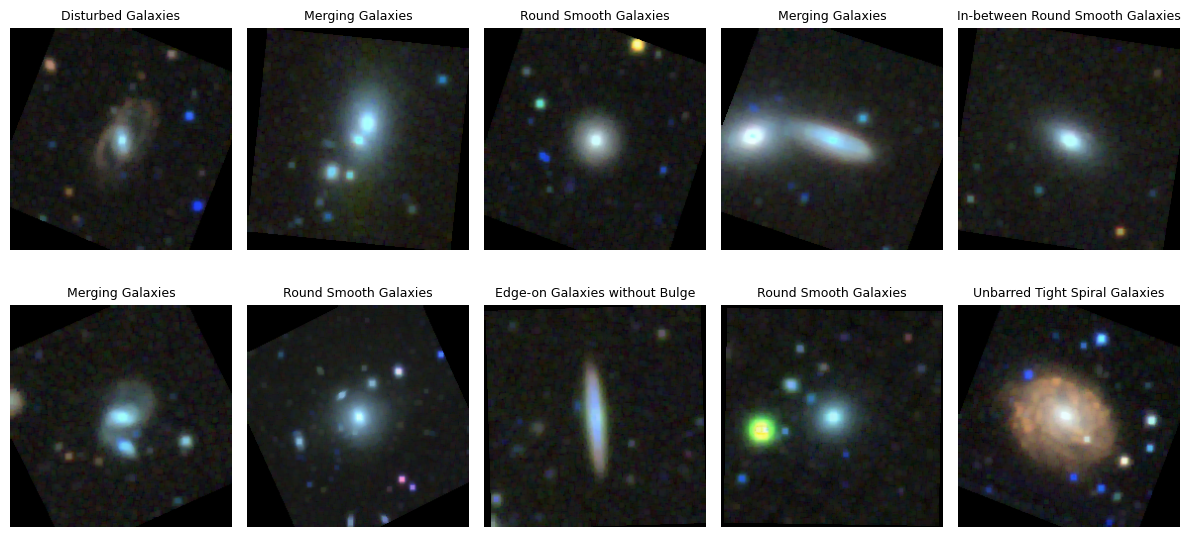

In [11]:
"""Randomly generate 10 images and their labels in traning set"""
TOTAL_TRA_BATCH = int(np.ceil(train_gen.samples/TRAIN_BATCH_SIZE))

# Randomly show 10 images from train data
fig, axs = plt.subplots(2, 5, figsize=(12,6))
for ax in axs.flatten():
    batch = np.random.randint(0, TOTAL_TRA_BATCH-1)
    b_index = np.random.randint(0, TRAIN_BATCH_SIZE)
    img = train_gen[batch][0][b_index]
    name = label_to_class[train_gen.classes[train_gen.index_array[batch*TRAIN_BATCH_SIZE+b_index]]]
    ax.imshow(img)
    ax.set_title(f'{name}', fontsize=9)
    ax.axis('off')

# Show the augmented data
fig.tight_layout()
fig.show()

In [12]:
"""Build and compile a CNN model for classification"""
# Define current training epoch
epochs = 0

# Try to load trained model to skip training or continue training
model_path = ''
if LOAD_MODEL:
    # Check directory to see if model file exists
    model_dirs = os.listdir(PATH_PREFIX+'model')
    for model_dir in model_dirs:
        if MODEL_NAME == model_dir.split('_')[0]:
            model_path = f'{PATH_PREFIX}model/{model_dir}'
            break

# We will build a new model if we didn't found trained model
if model_path == '':
    # Build a cnn model using pretrained model
    pretrained_model = tf.keras.applications.DenseNet201(
        input_shape = NN_IMG_SIZE + (3,),
        include_top = False,
        weights='imagenet'
    )
    pretrained_model.trainable = True

    # Connect pretrained model with dense layers
    player = pretrained_model.output
    flatten = Flatten(name='flatten')(player)
    dense_1 = Dense(1024, activation='relu',name='dense_1', kernel_regularizer='l2')(flatten)
    drop_1  = Dropout(0.3,name='drop_1')(dense_1)
    olayer  = Dense(10, activation='softmax',name='output')(drop_1)

    # Get model object
    model = Model(name = MODEL_NAME, inputs=[pretrained_model.input], outputs=[olayer])

    # Compile the CNN model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy']
    )
    print('-NOTICE: constract a new model.')

# If we found the path, we will load trained model and resume training epoch
else:
    model = tf.keras.models.load_model(model_path)
    epochs = int(model_path.split('_')[1])
    print(f'-NOTICE: load trained model, trained epoch is {epochs}.')

# Take a look at the model summary
model.summary()

-NOTICE: load trained model, trained epoch is 43.
Model: "DenseNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                         

In [13]:
"""Plot the CNN model"""
# # Plotting the model
# plot_model(model, show_shapes=True, show_layer_names=False)

'Plot the CNN model'

In [14]:
"""Define callbacks and start or continue model training"""
# We only train the model is current epochs is smaller than MAX_EPOCHS
is_skip = False
if epochs < MAX_EPOCHS:
    # Define callbacks earlystop, checkpoint and custom callback
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 20,
        verbose = 0,
        restore_best_weights = True
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=PATH_PREFIX+'model/'+MODEL_NAME+'_{epoch:03d}',
        save_weights_only=False,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )

    only = OnlyBestModel(
        name=MODEL_NAME,
        fdir=PATH_PREFIX+'model',
        ignore=[],
        copy=IN_COLAB,
        cdir='/content/drive/MyDrive/project/model',
        interval=1,
        cdel=True
    )

        
    # Start or continue training
    print(f'-NOTICE: training process start from {epochs} epochs, {MAX_EPOCHS} in total.')
    history = model.fit(
        train_gen,
        validation_data = valid_gen,
        epochs = MAX_EPOCHS,
        initial_epoch=epochs,
        class_weight=class_weights_dic,
        callbacks = [earlystop, checkpoint, only]
    )
    history_path = f'{PATH_PREFIX}model/{MODEL_NAME}_history.pkl'
    pk.dump(history.history, open(history_path,'wb'))
    print(f'-NOTICE: training process has finished.')

    # Save the model to my google drive if it's running on colab
    if IN_COLAB:
        # save history to drive
        target_dir = f'/content/drive/MyDrive/project/model/'
        shutil.copy(history_path, target_dir)

        # save model to drive
        source_dir = ''
        model_dirs = os.listdir(PATH_PREFIX+'model')
        for model_dir in model_dirs:
            if (MODEL_NAME == model_dir.split('_')[0]) and (int(model_dir.split('_')[1])>epochs):
                source_dir = f'{PATH_PREFIX}model/{model_dir}'
        target_dir = f'/content/drive/MyDrive/project/model/{model_dir}'
        copy_tree(source_dir, target_dir)
        print(f'-NOTICE: model {source_dir} copied to google drive successfully.')
else:
    is_skip = True
    print(f'-NOTICE: trained model epochs {epochs} is larger than {MAX_EPOCHS}, skiped training.')
    try:
        log_file = open(f'{PATH_PREFIX}model/{MODEL_NAME}_log.txt','r')
        print(f'-NOTICE: found training log for {MODEL_NAME} model.')
        for line in log_file.readlines():
            print(line.replace('\n',''))
    except:
        print(f'-NOTICE: no training log for {MODEL_NAME} model.')

-NOTICE: trained model epochs 43 is larger than 40, skiped training.
-NOTICE: found training log for DenseNet model.
-NOTICE: training process start from 0 epochs, 50 in total.
Epoch 1/50
400/400 [==============================] - 559s 1s/step - loss: 7.6747 - accuracy: 0.1913 - val_loss: 2.4236 - val_accuracy: 0.3023
Epoch 2/50
400/400 [==============================] - 300s 748ms/step - loss: 2.7742 - accuracy: 0.2546 - val_loss: 14.1674 - val_accuracy: 0.2728
Epoch 3/50
400/400 [==============================] - 398s 995ms/step - loss: 2.5227 - accuracy: 0.3327 - val_loss: 2.3535 - val_accuracy: 0.3183
Epoch 4/50
400/400 [==============================] - 294s 732ms/step - loss: 2.1877 - accuracy: 0.3638 - val_loss: 2.1836 - val_accuracy: 0.3173
Epoch 5/50
400/400 [==============================] - 327s 817ms/step - loss: 1.9990 - accuracy: 0.4144 - val_loss: 3.2996 - val_accuracy: 0.1822
Epoch 6/50
400/400 [==============================] - 282s 704ms/step - loss: 1.9106 - accuracy

-NOTICE: skiped training, using saved training history to plot.


C:\Users\14065\AppData\Local\Temp\ipykernel_2116\2660467240.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


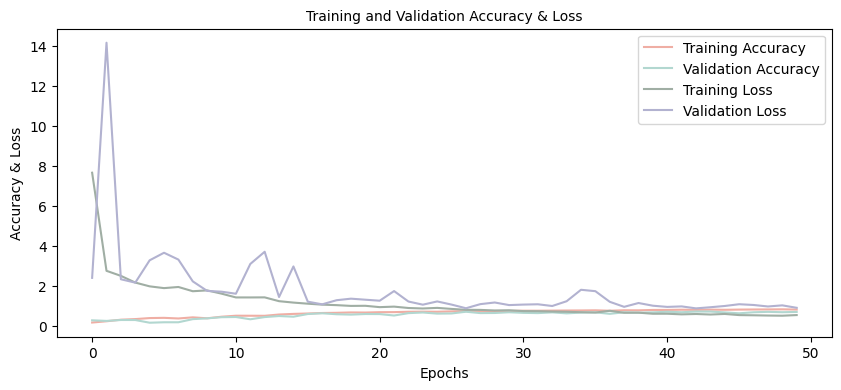

In [15]:
"""Plot the loss and accuracy of training"""
plotable = False

if is_skip:
    try:
        history_h = pk.load(open(f'{PATH_PREFIX}model/{MODEL_NAME}_history.pkl','rb'))
        print('-NOTICE: skiped training, using saved training history to plot.')
        plotable = True
    except:
        print('-NOTICE: skiped training, no history to plot with.')
        plotable = False
else:
    history_h = history.history

if plotable:
    fig = plt.figure(figsize=(10,4))
    ax = fig.gca()

    ax.plot(history_h['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
    ax.plot(history_h['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
    ax.plot(history_h['loss'],color='#A0AEA4',label = 'Training Loss')
    ax.plot(history_h['val_loss'],color='#B2B2D0',label = 'Validation Loss')
    ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy & Loss')
    ax.set_title('Training and Validation Accuracy & Loss', fontsize=10)

    fig.show()

## Section 4
**Evaluate trained model with validation result**

Code organization:


We first calculated predicted classes on validation set and generated a classification report for the validation set. Then we defined the class with highest f-2 score and randomly picked an image from the validation set with that label. After that we generated a saliency map and a GradCAM heatmap to show how our model recognize a galaxy and prove that it is working properly for the validation set.

In [16]:
# Calculate predicted classes on validation set
val_pred = model.predict(valid_gen)
val_pred_class = np.argmax(val_pred, axis=1)
val_true_class = valid_gen.classes

# Print out accuracy on validation set
print(f'Validation accuracy: {accuracy_score(val_true_class, val_pred_class):.4f}')

100/100 [==============================] - 563s 6s/step
Validation accuracy: 0.7313


In [17]:
# Generate a classification report on validation set
report = classification_report(val_true_class, val_pred_class, digits=5)
print(report)

              precision    recall  f1-score   support

           0    0.42007   0.58247   0.48812       194
           1    0.66738   0.93393   0.77847       333
           2    0.86694   0.86875   0.86785       480
           3    0.87452   0.63361   0.73482       363
           4    0.63768   0.72131   0.67692        61
           5    0.78846   0.67213   0.72566       366
           6    0.59950   0.71903   0.65385       331
           7    0.66201   0.49686   0.56766       477
           8    0.88750   0.84524   0.86585       252
           9    0.84731   0.85241   0.84985       332

    accuracy                        0.73126      3189
   macro avg    0.72514   0.73257   0.72091      3189
weighted avg    0.74756   0.73126   0.73116      3189



C:\Users\14065\AppData\Local\Temp\ipykernel_2116\1837284816.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


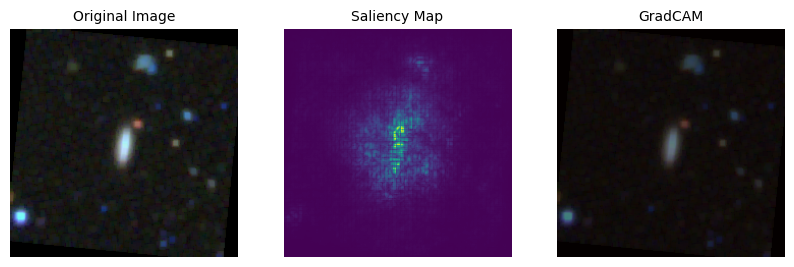

In [18]:
# Define the class label with highest f2-score
TARGET_CLASS_LABEL = 0
TARGET_CLASS_NAME  = label_to_class[TARGET_CLASS_LABEL]

# Randomly pick a image of given class from valgen
img_index = valid_gen.index_array[np.random.choice(np.where(valid_gen.classes==4)[0])]
img = valid_gen[img_index//VALID_BATCH_SIZE][0][img_index%VALID_BATCH_SIZE]

# Define a ReplaceToLinear object to change the activation of the output dense layer
replace2linear = ReplaceToLinear()

# Define loss function, and pass it the correct class label
score = CategoricalScore([TARGET_CLASS_LABEL])

# Create Saliency object
saliency = Saliency(
    model = model,
    model_modifier = replace2linear,
    clone = True
)

# Generate saliency map with smoothing by adding noise
saliency_map = saliency(
    score = score,
    seed_input = img,
    smooth_samples = 10,
    smooth_noise = 0.2,
    normalize_map = True
)

# Create Gradcam object
gradcam = Gradcam(
    model = model,
    model_modifier = replace2linear,
    clone = True
)

# Generate heatmap with GradCAM
cam_map = gradcam(
    score = score,
    seed_input = np.expand_dims(img, axis=0),
    normalize_cam = False,
)
heatmap = np.uint8(cm.hot(cam_map[0])[...,:3]*255)

# Arrange the 3 plots in a row using subplots
img_list = [img, saliency_map[0], img]
img_name = ['Original Image', 'Saliency Map', 'GradCAM']
fig, axs = plt.subplots(1, 3, figsize=(10,4))
for i in range(0,3):
    ax = axs[i]
    ax.imshow(img_list[i])
    ax.set_title(img_name[i], fontsize=10)
    ax.axis('off')
    if i == 2:
        ax.imshow(heatmap, cmap='hot', alpha=0.5)
fig.show()

## Section 5
**Evaluate trained model on test set**

Code organization:

To get a test data, we first made a test data image generator. Then we apply our model on this test set. To evaluate the performance, we plotted the confusion matrix.

In [19]:
"""Use ImageDataGenerator to generate test data"""
# Create main generator for test data
test_datagen = ImageDataGenerator(
    rescale=1/255,
    preprocessing_function=NN_PREPROCESS,
)

# Get ImageDataGenerator of test data
test_gen = test_datagen.flow_from_directory(
    directory=PATH_PREFIX+'data/test',
    target_size=NN_IMG_SIZE,
    class_mode='categorical',
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    seed=RANDOM_SEED,
)

Found 1774 images belonging to 10 classes.


In [20]:
"""Evaluate CNN model on test set"""
# Calculate predicted classes on validation set
test_pred = model.predict(test_gen)
test_pred_class = np.argmax(test_pred, axis=1)
test_true_class = test_gen.classes

# Print out accuracy on validation set
print(f'Test accuracy: {accuracy_score(test_true_class, test_pred_class):.4f}')

56/56 [==============================] - 318s 6s/step
Test accuracy: 0.7847


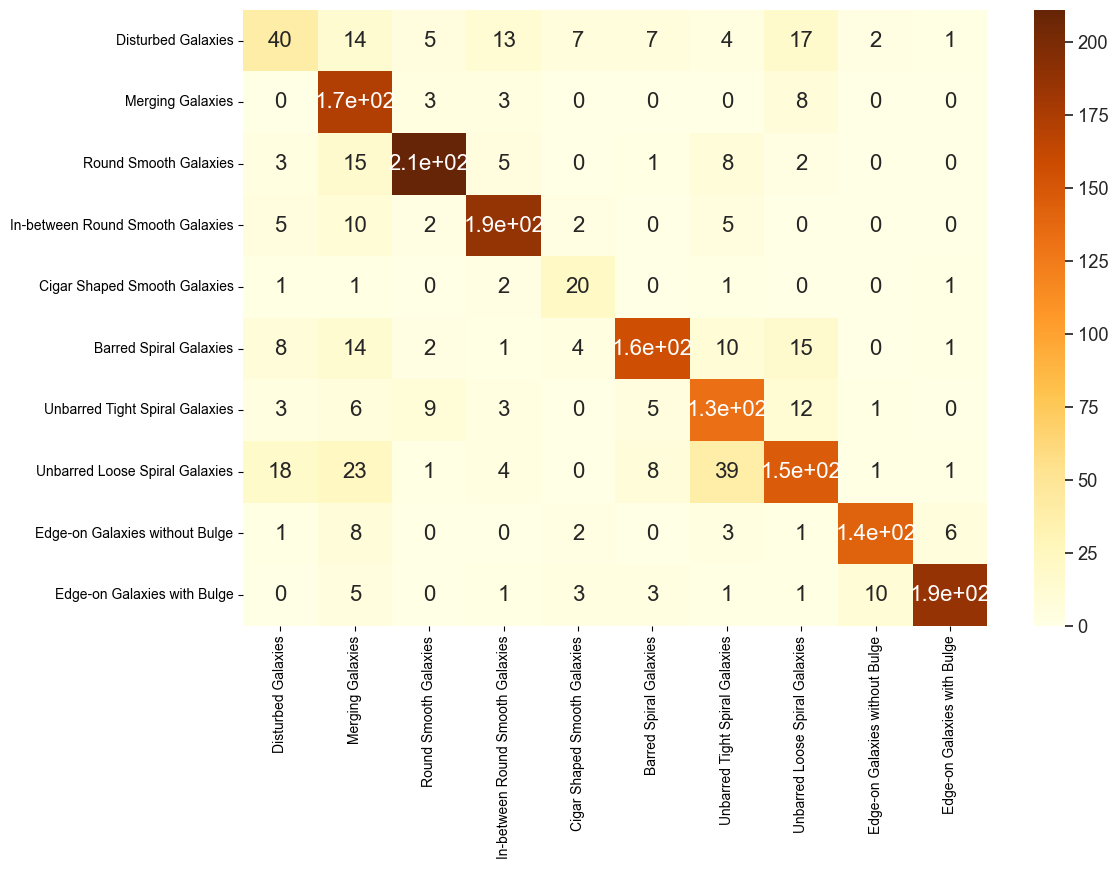

In [21]:
"""Plot confusion matrix"""
# Get the confusion matrix for the predictions
cf_matrix = confusion_matrix(test_true_class, test_pred_class)
fig,ax = plt.subplots(figsize=(12,8))
plot_confusion_matrix(cf_matrix, label_to_class, ax=ax)